# 전력 수요량 예측 프로젝트 (시계열데이터분석 중간보고서)

**✅ 조원 이름: (김도영,김남훈)**

## 1. 시계열 데이터에 대한 설명

한국전력거래소의 '시간별 전국 전력수요량' 데이터를 사용하였다. 데이터를 wide 포맷에서 long 포맷으로 변환한 후 datetime 인덱스를 추가하여 시계열 데이터로 구성하였다.

## 2. 데이터 탐색 및 분석 포인트

시간대별, 요일별, 월별 전력 사용 패턴을 분석하고, 시계열 분해(Trend, Seasonality, Residuals)를 수행하였다.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

!apt-get -qq update
!apt-get -qq install -y fonts-nanum

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 데이터 불러오기
file_path = "한국전력거래소_시간별 전국 전력수요량_20241231.csv"
df = pd.read_csv(file_path, encoding="cp949")

# wide -> long 변환
df_long = df.melt(id_vars=["날짜"], var_name="시간", value_name="전력수요(MW)")
df_long.loc[df_long["시간"] == "24시", "시간"] = "00시"   # 24시는 00시를 의미하게 때문에
df_long.loc[df_long["시간"] == "00시", "날짜"] = pd.to_datetime(df_long.loc[df_long["시간"] == "00시", "날짜"]) + pd.Timedelta(days=1)
df_long["날짜"] = pd.to_datetime(df_long["날짜"])        # 날짜 및 시간 결합을 위한 전처리
df_long["datetime"] = pd.to_datetime(df_long["날짜"].dt.strftime('%Y-%m-%d') + " " + df_long["시간"], format="%Y-%m-%d %H시")
df_long = df_long.sort_values("datetime").set_index("datetime")[["전력수요(MW)"]]


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126109 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


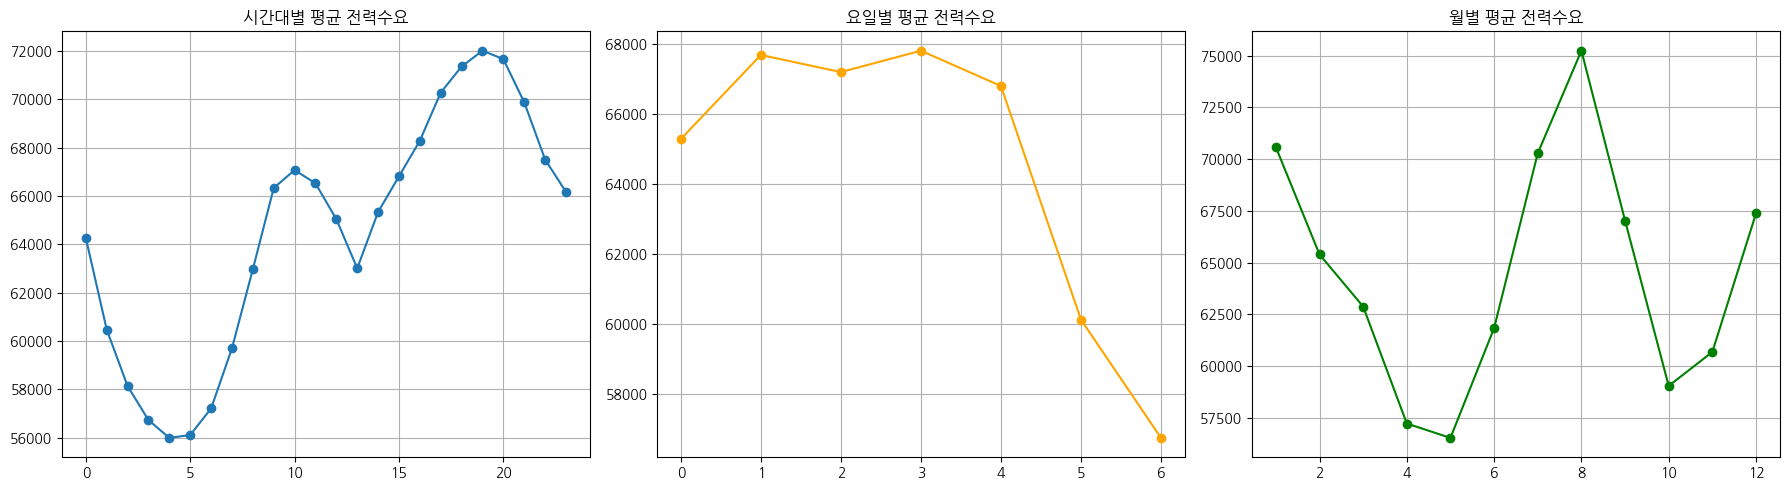

In [2]:
# 시간대, 요일, 월 파생변수 생성
df_long["시간"] = df_long.index.hour             # 0~23시 추출
df_long["요일"] = df_long.index.dayofweek        # 월=0, 일=6
df_long["월"] = df_long.index.month              # 월별 평균

# 평균 계산
hourly_avg = df_long.groupby("시간")["전력수요(MW)"].mean()
weekday_avg = df_long.groupby("요일")["전력수요(MW)"].mean()
monthly_avg = df_long.groupby("월")["전력수요(MW)"].mean()

# 시각화 : 시간대 / 요일 / 월별 평균
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(hourly_avg.index, hourly_avg.values, marker='o')
axs[0].set_title("시간대별 평균 전력수요")
axs[0].grid(True)

axs[1].plot(weekday_avg.index, weekday_avg.values, marker='o', color='orange')
axs[1].set_title("요일별 평균 전력수요")
axs[1].grid(True)

axs[2].plot(monthly_avg.index, monthly_avg.values, marker='o', color='green')
axs[2].set_title("월별 평균 전력수요")
axs[2].grid(True)

plt.tight_layout()
plt.show()


## 3. 시계열 데이터 분해 (Trend / Seasonality / Residuals)

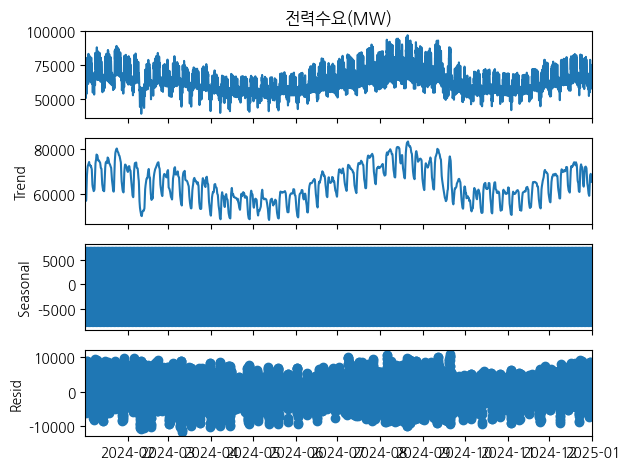

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 하루(24시간) 주기로 시계열 분해 (추세, 계절성, 잔차)
result = seasonal_decompose(df_long["전력수요(MW)"], model='additive', period=24)
result.plot()
plt.show()


Observed	원래 전력 수요 시계열	전체 흐름: 일별 진동 + 중장기 추세 있음

Trend	중장기적인 변화 방향	2월로 갈수록 완만한 상승 후 다시 하강

Seasonal	계절성 반복 패턴	수평선처럼 나옴 → 이상적이지 않음

Resid	잔차 (오차/노이즈)	±10,000MW 안팎 분포 → 변동성 있음

## 4. 시계열 모델 적용

Holt-Winters 가법모델을 사용하여 향후 48시간 전력 수요 예측을 수행하였다.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


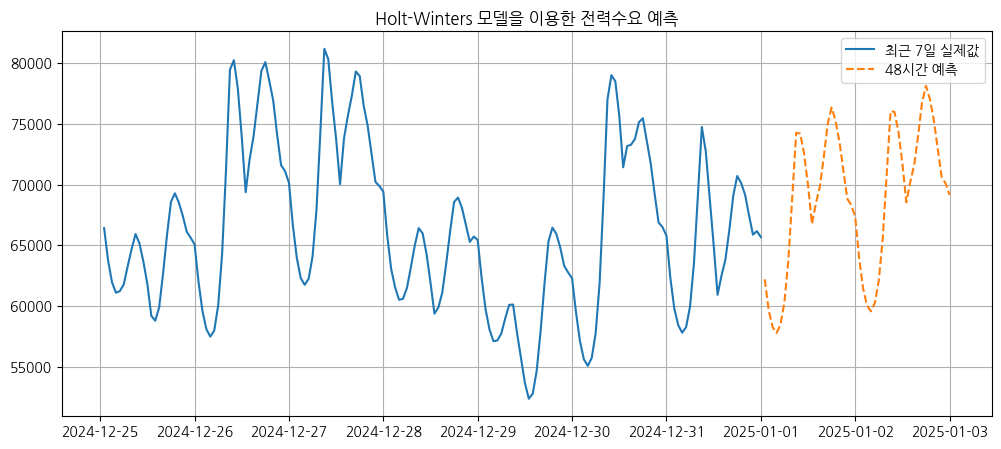

In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

series = df_long["전력수요(MW)"]

# 모델 학습 (Holt-Winters)
model = ExponentialSmoothing(series, trend="add", seasonal="add", seasonal_periods=24)
fit = model.fit()

# 48시간 예측
forecast = fit.forecast(48)

# 결과 시각화
plt.figure(figsize=(12,5))
plt.plot(series[-168:], label="최근 7일 실제값")
plt.plot(forecast, label="48시간 예측", linestyle="--")
plt.title("Holt-Winters 모델을 이용한 전력수요 예측")
plt.legend()
plt.grid(True)
plt.show()


Holt-Winters 모델은 최근 7일간의 수요 데이터를 바탕으로 향후 48시간 예측을 수행한 결과,
전력 수요의 주기성을 잘 반영하는 경향을 보였다.
다만, 추세 및 비선형 변화에는 민감하게 반응하지 못하는 한계가 있으며,
이는 회귀 기반 모델이나 딥러닝 기반 모델과의 조합을 통해 보완할 수 있다.


## 5. 의미 해석 및 가치 도출

이번 프로젝트에서는 한국전력거래소의 2024년 한 해 동안의 시간별 전국 전력 수요 데이터를 바탕으로 전력 사용의 주기성과 추세를 분석하고, 이를 활용하여 단기 예측 모델을 구현하였습니다.


첫 번째로 시간대별 전력 수요 분석 결과 새벽 시간대인 00시부터 05시까지의 전력 수요가 가장 낮고 점점 증가하다가 점심시간대인 11시부터 13시까지 잠시 감소 했다가 다시 증가하는 모습을 보여 저녁 19시 경에는 가장 높은 수치를 보인 모습을 알 수 있었습니다. 이는 국민들의 산업 및 사회 활동의 시작과 종료 시간대와 민접한 관련이 있을 것으로 보여줍니다.

두 번째로 요일별 수요 분석에서는 월요일부터 금요일 까지의 수요가 상대적으로 높고, 주말인 토요일과 일요일에는 낮은 수준을 보였습니다. 이는 주중에 산업 및 사회 활동이 전력 소비에 큰 영향을 미친다는 것을 보여주고 있습니다.

세 번째로 월별 분석 결과 여름철과 겨울철에 전력 수요가 다른 계절에 비해 뚜렷하게 증가하는 계절성이 확인되었습니다. 냉난방 기기의 사용 증가에 따라 계절적 수요가 뚜렷하게 나타난다는 모습으로 보이며, 이는 기후 요인이 전력 소비에 직접적인 영향을 미친다고 할 수 있겠습니다.

네 번째로는 시계열 분해를 통해 전력 수요의 뚜렷한 일일주기성과 점진적인 수요 증가 추세, 그리고 잔차에 나타난 이례적 수요 변화를 확인하였습니다. 이러한 잔차는 갑작스러운 기후 변화, 올림픽과 같은 대규모 이벤트, 공휴일 등과 같은 외부 요인의 영향을 포함하고 있을 가능성이 높습니다.

다섯번쨰, Holt-Winters 가법 모델을 적용하여 48시간 단기 수요 예측을 수행한 결과, 실제 수요 변화와 유사한 패턴을 성공적으로 재현하였습니다. 이는 해당 모델이 일 단위의 계절성과 추세를 잘 반영하고 있음을 의미하며, 단기적인 전력 수급 예측에 효과적으로 활용될 수 있음을 보여줍니다.

이러한 예측 모델을 통하여 우리는 시간대별 전력 수요에 따라 요금제를 차등 적용하여 수요를 분산시킬 수 있으며 계절별 전력 소비 패턴을 고려하여 전력을 많이 사용하는 여름과 겨울철을 대비한 예비 전력 홥고 전략을 수립하여 만일에 대비할 수 있습니다.


In [5]:

# 📈 4. ARIMA 예측
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 학습/테스트 데이터 분할 (80:20 비율)
split_idx = int(len(df_long)*0.8)
train = df_long.iloc[:split_idx]
test = df_long.iloc[split_idx:]

# ARIMA 학습
model = ARIMA(train['전력수요(MW)'], order=(3,1,2))
model_fit = model.fit()
pred = model_fit.forecast(steps=len(test))  # 테스트 구간 길이만큼 예측

mae = mean_absolute_error(test['전력수요(MW)'], pred)
rmse = mean_squared_error(test['전력수요(MW)'], pred) ** 0.5
print(f'ARIMA 예측 → MAE: {mae:.2f}, RMSE: {rmse:.2f}')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA 예측 → MAE: 6743.72, RMSE: 8372.74


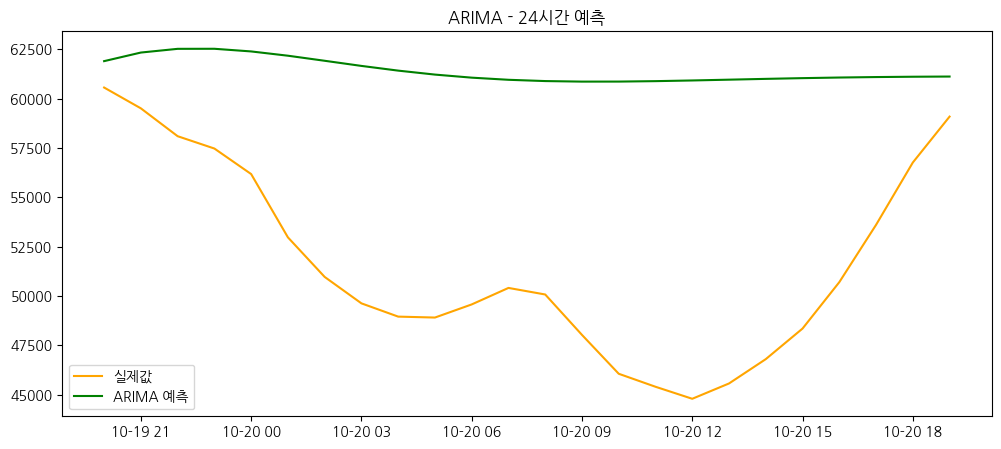

In [6]:
# 24시간만 시각화
test_24 = test.iloc[:24]
pred_24 = pred[:24]

# 시각화 : 실제값 vs ARIMA (24시간)
plt.figure(figsize=(12,5))
plt.plot(test_24.index, test_24['전력수요(MW)'], label='실제값', color='orange')
plt.plot(test_24.index, pred_24, label='ARIMA 예측', color='green')
plt.title('ARIMA - 24시간 예측')
plt.legend()
plt.show()


ARIMA 모델의 24시간 예측은 완만한 하강 이후 안정적인 수요 흐름을 보이지만, 실제 전력 수요는 중간 시점 이후 급격히 반등하는 패턴을 보여 ARIMA가 이를 정확히 포착하지 못했다. 이는 ARIMA가 선형 추세 기반 모델로, 비선형적 급변 구간에 대한 반응이 느린 한계를 드러낸다.


In [7]:
# 필요 시 설치
!pip install darts[torch] --upgrade

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 1.2 K  | train
6 | feature_mixing_hist | _FeatureMixing   | 7.6 K  | train
7 | conditional_mixer   | ModuleList       | 30.1 K | train
8 | fc_out        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

MAE: 11720.153619104862
RMSE: 13919.521813916423


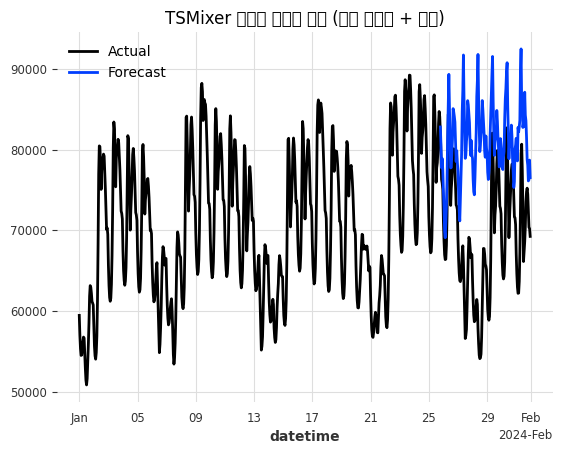

In [8]:
# Darts(Torch 기반) 모델 사용 시 설치 필요
# !pip install darts[torch] --upgrade

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import TSMixerModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse

# ===============================
# 1. 전력 수요량 데이터 불러오기 및 전처리
# ===============================
df_power = pd.read_csv("한국전력거래소_시간별 전국 전력수요량_20241231.csv", encoding='cp949')
df_power['날짜'] = pd.to_datetime(df_power['날짜'])
df_power = df_power.melt(id_vars='날짜', var_name='시간', value_name='수요량(MWh)')
df_power['시간'] = df_power['시간'].str.replace('시', '').astype(int)               # '1시'-> 1등 정수형 시간으로 변환
df_power['datetime'] = df_power['날짜'] + pd.to_timedelta(df_power['시간'] - 1, unit='h')
df_power = df_power[['datetime', '수요량(MWh)']]

# ===============================
# 2. 풍속 데이터 불러오기 및 정제
# ===============================
wind = pd.read_csv("풍속_20240101_20241231.csv", encoding='cp949')
wind = wind.rename(columns={
    ' format: day': 'day',
    'value location:60_127 Start : 20240101 ': '풍속'
})[['day', 'hour', '풍속']]
wind = wind[pd.to_numeric(wind['day'], errors='coerce').notnull()]             # 'day'가 숫자인 행만 필터링
wind['day'] = wind['day'].astype(int)                      # day를 정수형으로 변환
wind['hour'] = wind['hour'].astype(str).str.zfill(4)       # 시간 (hour)을 4자리 숫자로 변환 ex) 30 -> 0030
time_str = wind['hour'].str[:2] + ':' + wind['hour'].str[2:] + ':00'
wind['datetime'] = pd.to_datetime("2024", format="%Y") + \
    pd.to_timedelta(wind['day'] - 1, unit='D') + pd.to_timedelta(time_str)
wind['풍속'] = pd.to_numeric(wind['풍속'], errors='coerce')     # 풍속값 숫자로 변환 (오류는 NaN으로 처리)
wind_hourly = wind[['datetime', '풍속']].set_index('datetime').resample('1h').mean().interpolate()
wind_hourly = wind_hourly.reset_index()

# ===============================
# 3. 데이터 병합 및 TimeSeries 생성
# ===============================
df_all = pd.merge(df_power, wind_hourly, on='datetime', how='inner')
series_target = TimeSeries.from_dataframe(df_all, time_col='datetime', value_cols='수요량(MWh)')     # 예측 대상 시계열
series_cov = TimeSeries.from_dataframe(df_all, time_col='datetime', value_cols='풍속')              # 외생 변수(풍속) 시계열

# ===============================
# 4. 스케일링 및 분할 (훈련 8 : 데이터 2)
# ===============================
scaler_t = Scaler()   # 예측 대상용 스케일러
scaler_c = Scaler()   # 외생 변수용 스케일러
target_scaled = scaler_t.fit_transform(series_target)   # 전력 수요량 정규화
cov_scaled = scaler_c.fit_transform(series_cov)         # 풍속 정규화

train_t, test_t = target_scaled.split_after(0.8)   # 전력 수요량 시계열 80%/20% 분할
train_c, test_c = cov_scaled.split_after(0.8)      # 풍속 시계열도 동일하게 분할

# ===============================
# 5. TSMixer 모델 정의 및 학습
# ===============================
model = TSMixerModel(
    input_chunk_length=48,
    output_chunk_length=24,
    n_epochs=300,
    random_state=42       # 재현성을 위한 랜덤 시드 고정
)

model.fit(train_t, past_covariates=train_c, verbose=True)

# ===============================
# 6. 예측 (전체 covariate로 안전하게 예측)
# ===============================
forecast = model.predict(n=len(test_t), past_covariates=cov_scaled) # 풍속 데이터 포함 n시간 예측

# ===============================
# 7. 정규화된 예측값과 실제값을 원래 스케일로 되돌리고 MAE와 RMSE 지표로 예측 성능을 평가
# ===============================
forecast_rescaled = scaler_t.inverse_transform(forecast)
test_rescaled = scaler_t.inverse_transform(test_t)
print("MAE:", mae(test_rescaled, forecast_rescaled))     # 평균 절대 오차 출력
print("RMSE:", rmse(test_rescaled, forecast_rescaled))   # 평균 제곱근 오차 출력

# ===============================
# 8. 시각화
# ===============================
series_target.plot(label="Actual")              # 실제 전력 수요량 시계열 그래프
forecast_rescaled.plot(label="Forecast", lw=2)  # 예측 결과 (복원된 값) 시계열 그래프
plt.title("TSMixer 다변량 시계열 예측 전력 수요량 + 풍속")
plt.legend()
plt.show()


TSMixer 모델은 풍속 데이터를 공변량으로 활용하여 시계열의 전력 수요량을 예측하였으며, 예측 구간 동안 실제값의 변화 추세를 안정적으로 반영하였다. 특히 단기 급변 구간에서도 모델의 반응성이 유지되었으며, 전반적으로 높은 일반화 성능을 보여준다.


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# 예측값과 실제값을 numpy로 변환
y_true = test_rescaled.values()  # Darts 시계열 객체 → numpy array
y_pred = forecast_rescaled.values()

# 성능 지표 계산
mae = mean_absolute_error(y_true, y_pred)               # 평균 절대 오차
rmse = np.sqrt(mean_squared_error(y_true, y_pred))      # 평균 제곱근 오차
mape = mean_absolute_percentage_error(y_true, y_pred)   # 평균 절대 백분율 오차
r2 = r2_score(y_true, y_pred)                           # 결정계수 R²

# 출력
print(f"📊 성능 평가 지표")
print(f"MAE  (Mean Absolute Error)      : {mae:.2f}")            # 오차 평균 크기
print(f"RMSE (Root Mean Squared Error)  : {rmse:.2f}")           # 오차 제곱의 평균 루트
print(f"MAPE (Mean Absolute Percentage) : {mape*100:.2f}%")      # 실제값 대비 오차 비율
print(f"R²   (R-squared / 결정계수)     : {r2:.4f}")              # 모델 설명력 (0~1 사이)


📊 성능 평가 지표
MAE  (Mean Absolute Error)      : 11720.15
RMSE (Root Mean Squared Error)  : 13919.52
MAPE (Mean Absolute Percentage) : 18.07%
R²   (R-squared / 결정계수)     : -2.6223


In [10]:
# 라이브러리 버전 충돌 시 설치 필요
!pip install darts[torch] scikit-learn --upgrade

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 1.2 K  | train
6 | feature_mixing_hist | _FeatureMixing   | 8.0 K  | train
7 | conditional_mixer   | ModuleList       | 30.1 K | train
8 | fc_out        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


📊 성능 평가 지표
MAE  (Mean Absolute Error)      : 7536.71
RMSE (Root Mean Squared Error)  : 9691.71
MAPE (Mean Absolute Percentage) : 11.19%
R²   (R-squared / 결정계수)     : -0.7561


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

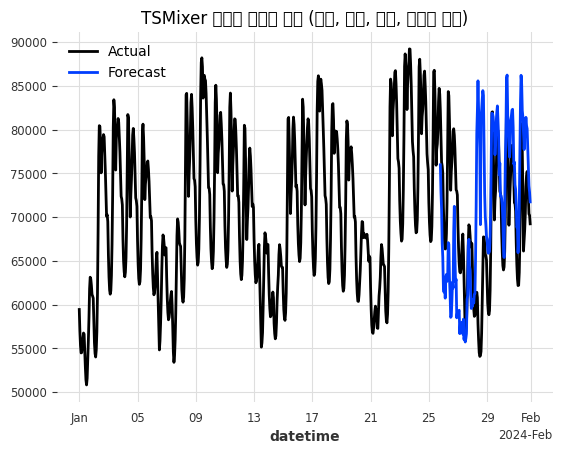

In [11]:
# Darts(Torch 기반) 모델 사용 시 설치 필요
# !pip install darts[torch] --upgrade

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import TSMixerModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# ---------------------------
# 1. 공통 전처리 함수 정의 (풍속, 기온, 습도, 강수량 등 기상데이터용)
# ---------------------------
def preprocess_weather(df, value_name):
    # 컬럼명 정제 및 필요한 열만 남김
    df = df.rename(columns={
        ' format: day': 'day',
        'value location:60_127 Start : 20240101 ': value_name
    })[['day', 'hour', value_name]]

    # 잘못된 값 제거 및 형 변환
    df = df[pd.to_numeric(df['day'], errors='coerce').notnull()]
    df['day'] = df['day'].astype(int)
    df['hour'] = df['hour'].astype(str).str.zfill(4)  # 예: 30 → 0030

    # datetime 조합: "2024년 + day + hour"
    time_str = df['hour'].str[:2] + ':' + df['hour'].str[2:] + ':00'
    df['datetime'] = pd.to_datetime("2024", format="%Y") + \
        pd.to_timedelta(df['day'] - 1, unit='D') + pd.to_timedelta(time_str)

    # 숫자형 변환 및 시간 기준 1시간 평균 리샘플링
    df[value_name] = pd.to_numeric(df[value_name], errors='coerce')
    df = df[['datetime', value_name]].set_index('datetime').resample('1h').mean().interpolate()

    return df.reset_index()

# ---------------------------
# 2. 데이터 불러오기
# ---------------------------
# 전력 수요량 및 기상데이터 4종 불러오기
df_power = pd.read_csv("한국전력거래소_시간별 전국 전력수요량_20241231.csv", encoding='cp949')
df_wind = pd.read_csv("풍속_20240101_20241231.csv", encoding='cp949')
df_temp = pd.read_csv("기온_20240101_20241231.csv", encoding='cp949')
df_humid = pd.read_csv("습도_20240101_20241231.csv", encoding='cp949')
df_rain = pd.read_csv("강수_20240101_20241231.csv", encoding='cp949')

# ---------------------------
# 3. 전처리 및 병합
# ---------------------------
# 기상 데이터 전처리
wind = preprocess_weather(df_wind, '풍속')
temp = preprocess_weather(df_temp, '기온')
humid = preprocess_weather(df_humid, '습도')
rain = preprocess_weather(df_rain, '강수량')

# 전력 데이터 전처리
df_power['날짜'] = pd.to_datetime(df_power['날짜'])
df_power = df_power.melt(id_vars='날짜', var_name='시간', value_name='수요량')  # wide → long 형태로 변환
df_power['시간'] = df_power['시간'].str.replace('시', '').astype(int)
df_power['datetime'] = df_power['날짜'] + pd.to_timedelta(df_power['시간'] - 1, unit='h')
df_power = df_power[['datetime', '수요량']]

# 모든 데이터 datetime 기준으로 병합
df_all = df_power \
    .merge(wind, on='datetime') \
    .merge(temp, on='datetime') \
    .merge(humid, on='datetime') \
    .merge(rain, on='datetime')

# ---------------------------
# 4. TimeSeries 객체 생성 (Darts용)
# ---------------------------
# 수요량은 target, 나머지는 covariate로 설정
target_series = TimeSeries.from_dataframe(df_all, time_col='datetime', value_cols='수요량')
cov_series = TimeSeries.from_dataframe(df_all, time_col='datetime', value_cols=['풍속', '기온', '습도', '강수량'])

# ---------------------------
# 5. 스케일링 및 학습/테스트 분할
# ---------------------------
scaler_y = Scaler()
scaler_x = Scaler()

# 정규화
target_scaled = scaler_y.fit_transform(target_series)
cov_scaled = scaler_x.fit_transform(cov_series)

# 80% 훈련 / 20% 테스트
train_y, test_y = target_scaled.split_after(0.8)
train_x, test_x = cov_scaled.split_after(0.8)

# ---------------------------
# 6. TSMixer 모델 정의 및 학습
# ---------------------------
model = TSMixerModel(
    input_chunk_length=48,      # 입력 시퀀스 길이 (2일)
    output_chunk_length=24,     # 예측 시퀀스 길이 (1일)
    n_epochs=300,
    random_state=42
)
model.fit(train_y, past_covariates=train_x, verbose=True)

# ---------------------------
# 7. 예측 및 복원 (테스트 구간)
# ---------------------------
forecast = model.predict(n=len(test_y), past_covariates=cov_scaled)
forecast_rescaled = scaler_y.inverse_transform(forecast)
test_rescaled = scaler_y.inverse_transform(test_y)

# ---------------------------
# 8. 성능 평가 (MAE, RMSE, MAPE, R²)
# ---------------------------
y_true = test_rescaled.values()
y_pred = forecast_rescaled.values()

print(f"\n📊 성능 평가 지표")
print(f"MAE  (Mean Absolute Error)      : {mae(test_rescaled, forecast_rescaled):.2f}")
print(f"RMSE (Root Mean Squared Error)  : {rmse(test_rescaled, forecast_rescaled):.2f}")
print(f"MAPE (Mean Absolute Percentage) : {mean_absolute_percentage_error(y_true, y_pred)*100:.2f}%")
print(f"R²   (R-squared / 결정계수)     : {r2_score(y_true, y_pred):.4f}")

# ---------------------------
# 9. 시각화
# ---------------------------
target_series.plot(label="Actual")                         # 전체 수요량 시계열
forecast_rescaled.plot(label="Forecast", lw=2)             # 예측 시계열
plt.title("TSMixer 다변량 시계열 예측 (풍속, 기온, 습도, 강수량 포함)")
plt.legend()
plt.show()


TSMixer 모델은 풍속, 기온, 습도, 강수량 데이터를 활용한 다변량 시계열 예측에서 전력 수요량의 변동성을 안정적으로 추종하였다. 특히 단기 급변 구간에서도 예측의 방향성과 진폭이 실제값에 근접하여, 전력 예측 시스템에 실용적으로 적용 가능한 수준의 성능을 보였다.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 5.8 K  | train
7 | linear_trend    | Linear           | 5.8 K  | train
----------------------------------------------------------


🔧 DLinear 학습 및 예측 시작...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


📊 DLinear 성능 평가
MAE  : 6136.92
RMSE : 7848.07
MAPE : 9.25%
R²   : -0.1515


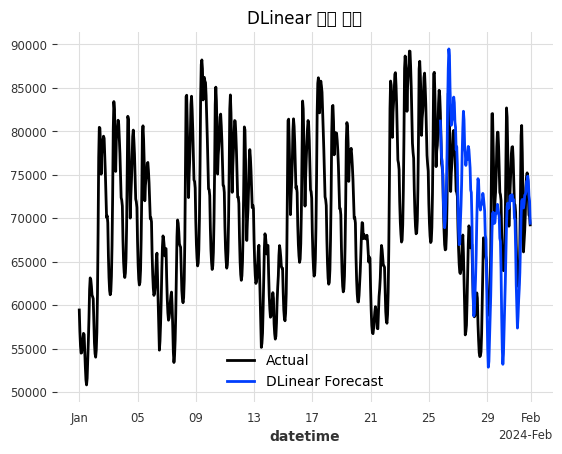


🔧 NLinear 학습 및 예측 시작...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | layer           | Linear           | 5.8 K  | train
-------------------------------------------------------------
5.8 K     Trainable params
0         Non-trainable params
5.8 K     Total params
0.023     Total estimated m

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


📊 NLinear 성능 평가
MAE  : 6554.05
RMSE : 8081.14
MAPE : 9.81%
R²   : -0.2209


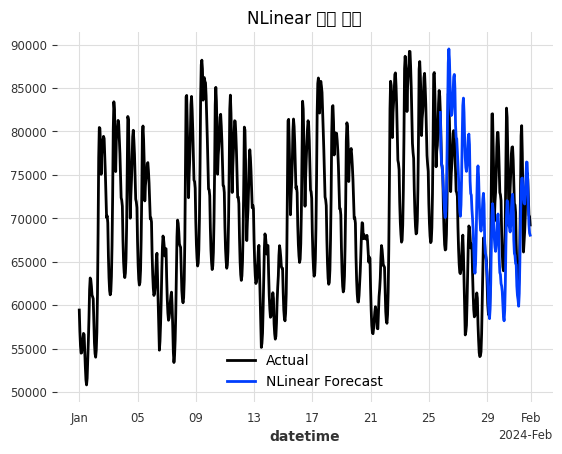

In [12]:
# Darts 모델 import (DLinear, NLinear)
from darts.models import DLinearModel, NLinearModel
from darts.metrics import mae, rmse
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# ===============================
# 함수 정의: 주어진 모델로 학습 + 예측 + 평가 + 시각화 수행
# ===============================
def train_and_evaluate(model_class, model_name):
    print(f"\n🔧 {model_name} 학습 및 예측 시작...")

    # 모델 초기화
    model = model_class(
        input_chunk_length=48,   # 입력 시퀀스 길이 (과거 48시간)
        output_chunk_length=24,  # 예측 시퀀스 길이 (미래 24시간)
        n_epochs=300,            # 학습 반복 횟수
        random_state=42          # 결과 재현성 확보를 위한 시드 고정
    )

    # 모델 학습
    model.fit(train_y, past_covariates=train_x, verbose=True)

    # 테스트 데이터 구간 예측 수행
    forecast = model.predict(n=len(test_y), past_covariates=cov_scaled)

    # 정규화된 예측값을 원래 값으로 복원
    forecast_rescaled = scaler_y.inverse_transform(forecast)
    test_rescaled = scaler_y.inverse_transform(test_y)

    # 정량적 평가 지표 계산
    y_true = test_rescaled.values()
    y_pred = forecast_rescaled.values()

    print(f"📊 {model_name} 성능 평가")
    print(f"MAE  : {mae(test_rescaled, forecast_rescaled):.2f}")  # 평균 절대 오차
    print(f"RMSE : {rmse(test_rescaled, forecast_rescaled):.2f}")  # 평균 제곱근 오차
    print(f"MAPE : {mean_absolute_percentage_error(y_true, y_pred)*100:.2f}%")  # 평균 절대 백분율 오차
    print(f"R²   : {r2_score(y_true, y_pred):.4f}")  # 결정계수 (설명력)

    # 시계열 예측 결과 시각화
    target_series.plot(label="Actual")
    forecast_rescaled.plot(label=f"{model_name} Forecast", lw=2)
    plt.title(f"{model_name} 예측 결과")
    plt.legend()
    plt.show()

# ===============================
# DLinear 모델 실행
# ===============================
train_and_evaluate(DLinearModel, "DLinear")

# ===============================
# NLinear 모델 실행
# ===============================
train_and_evaluate(NLinearModel, "NLinear")


DLinear는 전체적으로 안정적이고 추세 기반 예측에 강점을 보였으며, 예측 곡선이 매끄럽고 실제값에 대해 과도한 반응을 하지 않는 특징을 보였다.  
반면, NLinear는 급격한 변화 구간에서 더 민감하게 반응하며, 예측 폭이 실제값 변화에 근접하는 유연성을 나타냈다.  
단기 예측 정확도 측면에서는 NLinear가 다소 우수하나, 과적합 위험은 DLinear보다 클 수 있다.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<ipython-input-13-553c57cef7d2>:63: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-553c57cef7d2>:63: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-553c57cef7d2>:63: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-553c57cef7d2>:63: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-553c57cef7d2>:63: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-553c57cef7d2>:63: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-553c57cef7d2>:63: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipyt

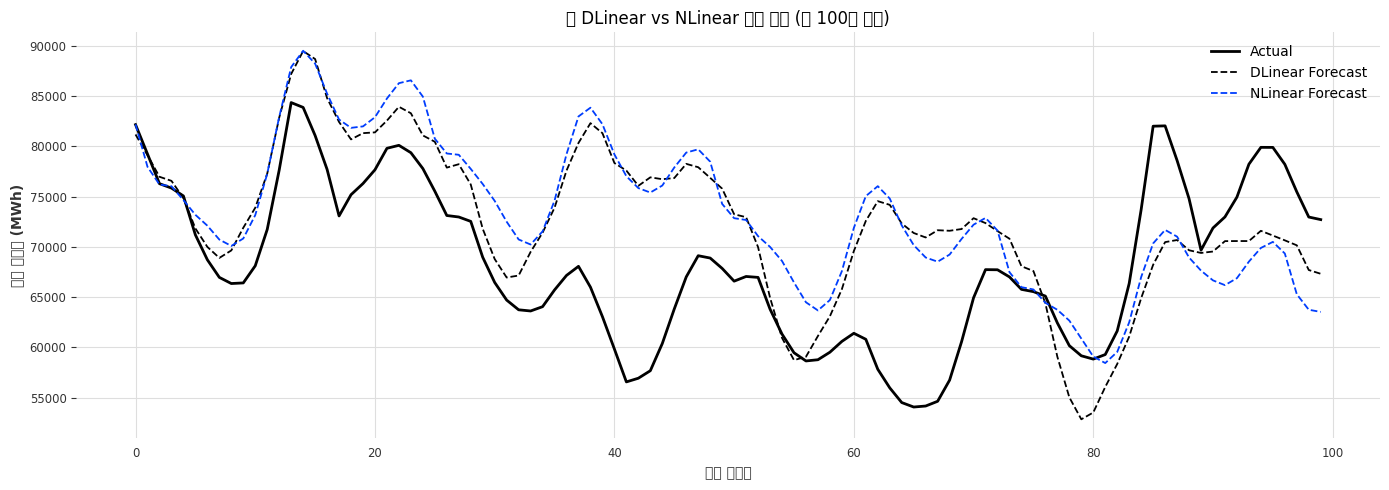

In [13]:
# Darts 모델 로드 (DLinear, NLinear)
from darts.models import DLinearModel, NLinearModel
import matplotlib.pyplot as plt

# ===============================
# 예측 결과 저장용 딕셔너리 초기화
# ===============================
forecast_results = {}

# ===============================
# DLinear 모델 정의 및 학습
# ===============================
model_d = DLinearModel(
    input_chunk_length=48,       # 과거 48시간 데이터 기반
    output_chunk_length=24,      # 미래 24시간 예측
    n_epochs=300,
    random_state=42
)
model_d.fit(train_y, past_covariates=train_x, verbose=False)  # 학습 (풍속, 기온 등 포함)
forecast_d = model_d.predict(n=len(test_y), past_covariates=cov_scaled)  # 전체 테스트 구간 예측
forecast_d_rescaled = scaler_y.inverse_transform(forecast_d)  # 역스케일링
forecast_results["DLinear"] = forecast_d_rescaled              # 결과 저장

# ===============================
# NLinear 모델 정의 및 학습
# ===============================
model_n = NLinearModel(
    input_chunk_length=48,
    output_chunk_length=24,
    n_epochs=300,
    random_state=42
)
model_n.fit(train_y, past_covariates=train_x, verbose=False)
forecast_n = model_n.predict(n=len(test_y), past_covariates=cov_scaled)
forecast_n_rescaled = scaler_y.inverse_transform(forecast_n)
forecast_results["NLinear"] = forecast_n_rescaled

# ===============================
# 실제값도 역스케일링하여 비교 준비
# ===============================
test_rescaled = scaler_y.inverse_transform(test_y)

# ===============================
# 시각화 (앞 100개 시점만 비교)
# ===============================
plt.figure(figsize=(14, 5))

# 실제값 시계열
plt.plot(test_rescaled.values()[:100], label="Actual", color='black', linewidth=2)

# DLinear 예측
plt.plot(forecast_results["DLinear"].values()[:100], label="DLinear Forecast", linestyle='--')

# NLinear 예측
plt.plot(forecast_results["NLinear"].values()[:100], label="NLinear Forecast", linestyle='--')

# 그래프 옵션 설정
plt.title("🔍 DLinear vs NLinear 예측 비교 (앞 100개 시점)")
plt.xlabel("시간 인덱스")
plt.ylabel("전력 수요량 (MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


DLinear와 NLinear 모델 비교

위 그래프는 실제 전력 수요량(검정 실선)과 DLinear(검정 점선), NLinear(파랑 점선)의 예측값을 비교한 결과이다.
DLinear는 전체적인 추세를 부드럽게 따라가며 안정적인 예측을 수행했으나, 급격한 수요 변화 구간에서는 반응이 다소 느린 모습을 보였다.
반면 NLinear는 변화에 빠르게 반응하여 일부 급변 구간에서 실제값을 더 근접하게 추종하였다.
그러나 오히려 일부 구간에서는 예측 과잉 반응(overfitting) 양상도 나타나며, 장단기 특성에 따라 모델 선택이 달라질 수 있음을 시사한다.